# Day 5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 역전파 신경망

/module/neuralnet_backprop.py

In [2]:
import numpy as np

class Sigmoid:
    def __init__(self):
        self.y = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        self.y = y
        return y

    def backward(self, dout):
        dx = dout * self.y * (1 - self.y)
        return dx

class 완전연결:
    def __init__(self, 입력수, 출력수, 활성화=None):
        self.W = np.random.randn(입력수, 출력수)
        self.b = np.zeros(출력수)
        self.activation = 활성화
        self.x = None
        self.dW = None
        self.db = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        self.x = x
        z = np.dot(x, self.W) + self.b
        if self.activation:
            return self.activation(z)
        return z

    def backward(self, dout):
        if self.activation:
            dout = self.activation.backward(dout)
            
        self.dW = np.dot(self.x.T, dout)
        # 배치 단위 연산 시, 미분값을 모든 표본에 대해 더합니다.
        self.db = np.sum(dout, axis=0)
        
        dx = np.dot(dout, self.W.T)
        return dx

def softmax(z):
    if z.ndim == 1:
        z = z.reshape(1, -1)
    exp_z = np.exp(z - np.max(z, axis=1).reshape(-1, 1))
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

def 교차엔트로피오차(y, y_pred):
    delta = 1e-7
    배치크기 = y.shape[0]
    return -np.sum(y * np.log(y_pred + delta)) / 배치크기

class CrossEntropy:
    def __init__(self, from_logits=False):
        self.y = None
        self.from_logits = from_logits
        self.proba = None

    def __call__(self, z, y):
        return self.forward(z, y)

    def forward(self, outputs, y):
        self.y = y
        # z -> softmax -> proba
        if not self.from_logits:      
            self.proba = outputs
        else: # from_logits=True -> 실수값 -> 확률값
            self.proba = softmax(outputs)
        # CEE(y, proba)
        손실 = 교차엔트로피오차(y, self.proba)
        return 손실

    def backward(self, dout=1):
        배치크기 = len(self.y)
        dz = self.proba - self.y
        return dz / 배치크기

class 역전파신경망:
    def __init__(self, 손실함수):
        self.layers = []
        self.loss_func = 손실함수

    def add(self, layer):
        self.layers.append(layer)

    def __call__(self, x):
        """순전파"""
        outputs = x
        for layer in self.layers:
            outputs = layer(outputs)
        return outputs # z_last

    def 손실산출(self, x, y):
        outputs = self(x)
        손실 = self.loss_func(outputs, y)
        return 손실

    def fit(self, x, y, 배치크기, 에폭수, 학습률):
        에폭당_배치수 = len(x) // 배치크기
        학습횟수 = 에폭당_배치수 * 에폭수
        print(f'배치크기={배치크기}, 에폭수={에폭수}, 학습횟수={학습횟수}({에폭당_배치수}/에폭)')
        손실변화 = []
        for 학습 in range(학습횟수):
            # 1. 미니 배치
            표본수 = S = len(x)
            배치색인 = np.random.choice(표본수, 배치크기)
            x_batch = x[배치색인]
            y_batch = y[배치색인]
            # 2. 경사 산출 (역전파)
            # 1) 순전파
            손실 = self.손실산출(x_batch, y_batch)
            손실변화.append(손실)
            # 2) 역전파            
            dout = self.loss_func.backward(1)
            for layer in reversed(self.layers):
                dout = layer.backward(dout)
            # 3. 매개변수 갱신 (경사 하강)
            for layer in self.layers:
                if isinstance(layer, 완전연결):
                    layer.W -= layer.dW * 학습률
                    layer.b -= layer.db * 학습률

            if 학습 == 0 or (학습 + 1) % 100 == 0:
                print(f'[학습 {학습 + 1}] Loss: {손실:.3f}')
        return 손실변화


In [3]:
#MNIST

from torchvision.datasets import MNIST

mnist = {}
mnist['train'] = MNIST(root='~/data', train=True, download=True) # ~/의 의미 : 홈 디렉토리 (바인드 되어 있는 이 컴퓨터 디렉토리가 아님.)
mnist['test'] = MNIST(root='~/data', train=False, download=True)


def 전처리(images):
    if not isinstance(images, np.ndarray):
        images = images.numpy()
    X = images.reshape(-1, 28*28).astype(np.float32) / 255.0    
    return X

train_data = 전처리(mnist['train'].data)
train_target = np.array(mnist['train'].targets)
test_data = 전처리(mnist['test'].data)
test_target = np.array(mnist['test'].targets)

배치크기=100, 에폭수=10, 학습횟수=6000(600/에폭)
[학습 1] Loss: 6.813
[학습 100] Loss: 0.878
[학습 200] Loss: 0.767
[학습 300] Loss: 0.397
[학습 400] Loss: 0.885
[학습 500] Loss: 0.387
[학습 600] Loss: 0.528
[학습 700] Loss: 0.292
[학습 800] Loss: 0.412
[학습 900] Loss: 0.385
[학습 1000] Loss: 0.150
[학습 1100] Loss: 0.309
[학습 1200] Loss: 0.285
[학습 1300] Loss: 0.156
[학습 1400] Loss: 0.223
[학습 1500] Loss: 0.176
[학습 1600] Loss: 0.319
[학습 1700] Loss: 0.286
[학습 1800] Loss: 0.146
[학습 1900] Loss: 0.207
[학습 2000] Loss: 0.182
[학습 2100] Loss: 0.229
[학습 2200] Loss: 0.159
[학습 2300] Loss: 0.291
[학습 2400] Loss: 0.090
[학습 2500] Loss: 0.105
[학습 2600] Loss: 0.481
[학습 2700] Loss: 0.139
[학습 2800] Loss: 0.187
[학습 2900] Loss: 0.187
[학습 3000] Loss: 0.242
[학습 3100] Loss: 0.155
[학습 3200] Loss: 0.126
[학습 3300] Loss: 0.136
[학습 3400] Loss: 0.186
[학습 3500] Loss: 0.114
[학습 3600] Loss: 0.153
[학습 3700] Loss: 0.197
[학습 3800] Loss: 0.244
[학습 3900] Loss: 0.116
[학습 4000] Loss: 0.305
[학습 4100] Loss: 0.066
[학습 4200] Loss: 0.060
[학습 4300] Loss: 0.120
[학습 4400

<Axes: >

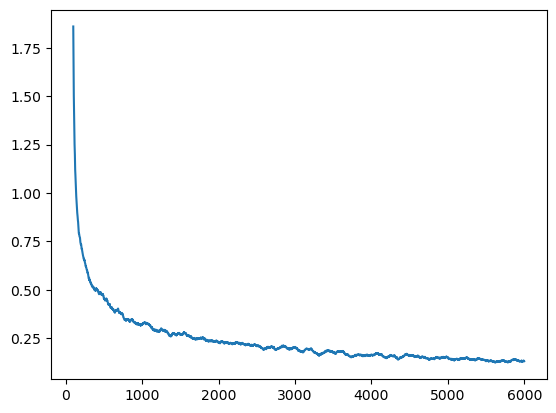

In [24]:
원핫행렬 = np.eye(10)

model = 역전파신경망(CrossEntropy(from_logits=True))
model.add(완전연결(784, 50, 활성화=Sigmoid()))
model.add(완전연결(50, 100, 활성화=Sigmoid()))
model.add(완전연결(100, 10, 활성화=None))

loss_history = model.fit(train_data, 원핫행렬[train_target], 배치크기=100, 에폭수=10, 학습률=1)

# 평가: 테스트 데이터에 대한 성능 측정
test_pred_score = model(test_data)
test_pred = np.argmax(test_pred_score, axis=1)

# 정확도 계산
accuracy = np.mean(test_pred == test_target)

# 손실값 계산
y_onehot = 원핫행렬[test_target]
test_loss = model.loss_func(test_pred_score, y_onehot)

print(f'테스트 손실: {test_loss:.3f}')
print(f'테스트 정확도: {accuracy:.3f}')

pd.Series(loss_history).rolling(window=100).mean().plot()



## PyTorch

PyTorch = Numpy + GPU + Back_prop + ...

In [43]:
import torch

사과단가 = torch.tensor(100.0, requires_grad=True)
사과수량 = torch.tensor(2.0, requires_grad=True)
부가세 = torch.tensor(0.1)

사과가격 = 사과단가 * 사과수량 * (1 + 부가세)
사과가격.backward()

pd.DataFrame({
    '사과단가': [사과단가.item(), 사과단가.grad.item()],
    '사과수량': [사과수량.item(), 사과수량.grad.item()],
    '부가세': [부가세.item(), 부가세.grad]
    }, index = ['순전파', '역전파'])

,사과단가,사과수량,부가세
순전파,100.0,2.0,0.1
역전파,2.2,110.0,NaN


In [45]:
print(사과단가) # 텐서 객체
print(사과단가.item()) # 텐서 객체의 값
print(사과단가.grad) # 텐서 객체의 미분값


tensor(100., requires_grad=True)
100.0
tensor(2.2000)


## 파이토치 신경망

In [59]:
import torch

class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None):
        self.W = torch.randn(입력수, 출력수, requires_grad=True)
        self.b = torch.zeros(출력수, requires_grad=True)
        self.활성화 = 활성화

    def __call__(self, x):
        z = torch.matmul(x, self.W) + self.b
        if self.활성화:
            return self.활성화(z)
        return z

layer = 다중퍼셉트론(2, 3, 활성화=torch.sigmoid)
print(layer.W.shape, layer.b.shape)
assert layer.W.requires_grad and layer.b.requires_grad

X = torch.linspace(0, 1, 10).reshape(5, 2)
outputs = layer(X)


torch.Size([2, 3]) torch.Size([3])


In [ ]:
import torch.nn as nn # 신경망 모듈

layer = nn.Linear(in_features=2, out_features=3) # Linear:활성화 함수 없음
print(layer.weight.shape, layer.bias.shape)
assert layer.weight.requires_grad and layer.bias.requires_grad

X = torch.linspace(0, 1, 10).reshape(5, 2)
assert torch.allclose(layer(X), torch.matmul(X, layer.weight.T) + layer.bias)

# 활성화
Z = torch.sigmoid(layer(X)) # 선형 결합 -> 활성화 함수 -> 비선형 결합

torch.Size([3, 2]) torch.Size([3])


In [ ]:
# 배치가 없는 경우 : 안 좋다. 

model = nn.Sequential(
    #은닉층
    nn.Linear(784, 50),
    nn.Sigmoid(), # 비선형 활성화
    nn.Linear(50, 100),
    nn.Sigmoid(),
    #출력층
    nn.Linear(100, 10),
    #nn.Softmax(dim=1) # 출력층 활성화 함수
)

#학습
손실함수 = nn.CrossEntropyLoss() # 로짓값을 입력으로 받음, 정답은 정수값 (원핫인코딩을 하지 않음)
학습률 = 1.0
학습횟수 = 100

train_data = mnist['train'].data.reshape(-1, 784).float()/255.0
train_target = mnist['train'].targets
for 학습 in range(학습횟수):
    outputs = model(train_data)
    손실 = 손실함수(outputs, train_target)
    print(f'[에폭 {학습 + 1}] 손실: {손실.item():.3f}')
    손실변화 = []
    손실변화.append(손실.item())
    #print(f'손실: {손실.item():.3f}')

    # 손실의 type
    #print(f'손실의 type: {type(손실)}')

    #역전파
    손실.backward()
    #매개변수 갱신
    with torch.no_grad(): # 이 코드의 의미 : 이 코드 안에서는 기울기를 계산하지 않음
        for param in model.parameters():
            param -= 학습률 * param.grad # 더하는 것이 아니라 빼는 이유 : 기울기가 양수일 때, 값이 줄어들기 때문
        model.zero_grad() # 기울기 초기화 이유 : 여러 번 반복 학습할 때, 기울기가 누적되기 때문

# 평가
test_data = mnist['test'].data.reshape(-1, 784).float()/255.0
outputs = model(test_data)
print(outputs.shape)
y_pred = torch.argmax(outputs, dim=1)
print(f'정확도: {torch.sum(y_pred == test_target) / len(test_target)}')


[에폭 1] 손실: 2.371
[에폭 2] 손실: 2.444
[에폭 3] 손실: 2.495
[에폭 4] 손실: 2.483
[에폭 5] 손실: 2.573
[에폭 6] 손실: 2.459
[에폭 7] 손실: 2.502
[에폭 8] 손실: 2.447
[에폭 9] 손실: 2.472
[에폭 10] 손실: 2.401
[에폭 11] 손실: 2.406
[에폭 12] 손실: 2.372
[에폭 13] 손실: 2.375
[에폭 14] 손실: 2.347
[에폭 15] 손실: 2.348
[에폭 16] 손실: 2.330
[에폭 17] 손실: 2.330
[에폭 18] 손실: 2.317
[에폭 19] 손실: 2.318
[에폭 20] 손실: 2.309
[에폭 21] 손실: 2.310
[에폭 22] 손실: 2.303
[에폭 23] 손실: 2.304
[에폭 24] 손실: 2.298
[에폭 25] 손실: 2.300
[에폭 26] 손실: 2.295
[에폭 27] 손실: 2.296
[에폭 28] 손실: 2.292
[에폭 29] 손실: 2.293
[에폭 30] 손실: 2.289
[에폭 31] 손실: 2.290
[에폭 32] 손실: 2.286
[에폭 33] 손실: 2.286
[에폭 34] 손실: 2.282
[에폭 35] 손실: 2.283
[에폭 36] 손실: 2.279
[에폭 37] 손실: 2.279
[에폭 38] 손실: 2.275
[에폭 39] 손실: 2.275
[에폭 40] 손실: 2.271
[에폭 41] 손실: 2.271
[에폭 42] 손실: 2.266
[에폭 43] 손실: 2.265
[에폭 44] 손실: 2.260
[에폭 45] 손실: 2.260
[에폭 46] 손실: 2.254
[에폭 47] 손실: 2.253
[에폭 48] 손실: 2.246
[에폭 49] 손실: 2.245
[에폭 50] 손실: 2.237
[에폭 51] 손실: 2.236
[에폭 52] 손실: 2.227
[에폭 53] 손실: 2.225
[에폭 54] 손실: 2.215
[에폭 55] 손실: 2.213
[에폭 56] 손실: 2.201
[

In [ ]:
def build_model():
    model = nn.Sequential(
        nn.Linear(784, 50),
        nn.Sigmoid(),
        nn.Linear(50, 100),
        nn.Sigmoid(),
        nn.Linear(100, 10),
    )
    return model



## 배치 크기

In [155]:
import time

model = build_model() # 신경망 모델 생성 (초기화)
손실함수 = nn.CrossEntropyLoss() # 손실 함수 생성
result = {}
학습률 = 1.0
학습횟수 = 100
train_data = mnist['train'].data.reshape(-1, 784).float()/255.0
train_target = mnist['train'].targets

# 처음 시작 시, "워밍 업" 단계
_ = model(train_data)

for 배치크기 in [1, 10, 100, 1000, 6000, len(train_data)]:
    배치색인 = torch.randperm(len(train_data))[:배치크기]
    소요시간 = []
    for __ in range(5): # 5회 반복 후 평균 시간 측정
        start = time.time()
        outputs = model(train_data[배치색인])
        손실 = 손실함수(outputs, train_target[배치색인])
        end = time.time()
        소요시간.append(end - start)
    result[배치크기] = {'손실': 손실.item(), '소요시간ms': np.mean(소요시간)*1000}


pd.DataFrame(result).round(3).T

,손실,소요시간ms
1,2.178,0.260
10,2.236,0.278
100,2.323,0.469
1000,2.325,2.076
6000,2.324,8.398
60000,2.327,109.309


In [183]:
import time

model = build_model() # 신경망 모델 생성 (초기화)
손실함수 = nn.CrossEntropyLoss() # 손실 함수 생성
최적화 = torch.optim.SGD(model.parameters(), lr=1.0)

에폭수 = 10
배치크기 = 100
에폭당_배치수 = len(train_data) // 배치크기
학습횟수 = 에폭당_배치수 * 에폭수
print(f'배치크기={배치크기}, 에폭수={에폭수}, 학습횟수={학습횟수}({에폭당_배치수}/에폭)')

손실변화 = []
에폭당_소요시간 = []
for 에폭 in range(에폭수):
    start = time.time()
    for __ in range(에폭당_배치수):        
        배치색인 = torch.randperm(len(train_data))[:배치크기]
        batch_data = train_data[배치색인]
        batch_target = train_target[배치색인]
        #print(batch_data.shape, batch_target.shape)

        #순전파
        loss = 손실함수(model(batch_data), batch_target)
        손실변화.append(loss.item())       

        #역전파
        loss.backward()

        #매개변수 갱신
        최적화.step()
        최적화.zero_grad()

    end = time.time()
    에폭당_소요시간.append(end - start)
    print(f'{에폭 + 1} 에폭 // 소요시간: {에폭당_소요시간[-1]:.3f}초, 손실: {손실변화[-1]:.3f}')

# 평가
outputs = model(test_data)
y_pred = torch.argmax(outputs, dim=1)
print(f'정확도: {torch.sum(y_pred == test_target) / len(test_target)}')

배치크기=100, 에폭수=10, 학습횟수=6000(600/에폭)
1 에폭 // 소요시간: 1.708초, 손실: 0.389
2 에폭 // 소요시간: 1.249초, 손실: 0.293
3 에폭 // 소요시간: 1.194초, 손실: 0.107
4 에폭 // 소요시간: 1.203초, 손실: 0.173
5 에폭 // 소요시간: 1.167초, 손실: 0.103
6 에폭 // 소요시간: 1.241초, 손실: 0.083
7 에폭 // 소요시간: 1.261초, 손실: 0.062
8 에폭 // 소요시간: 1.211초, 손실: 0.096
9 에폭 // 소요시간: 1.208초, 손실: 0.074
10 에폭 // 소요시간: 1.225초, 손실: 0.078
정확도: 0.9703999757766724
